In [1]:
# Install pytorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install other libraries
!pip install opencv-python matplotlib pycocotools

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
# Install compatible Detectron2 version for current PyTorch
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-_ythatl8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-_ythatl8
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.6 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733314 sha256=aca81cd5cc7dcf6b7aae5db45aea85c9f7fbe21ab3e08876f20938d8c11d66e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-rz_9qie0/wheels/d3/6e/bd/1969578f1456a6be

In [ ]:
# !pip uninstall -y detectron2

In [3]:
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer

print("Detectron2 installed successfully!")

Detectron2 installed successfully!


In [4]:
# Download COCO 2017 train and val datasets
!mkdir -p coco_dataset

# Download val2017 images (~1GB)
!wget -q http://images.cocodataset.org/zips/val2017.zip -O coco_dataset/val2017.zip
!unzip -q coco_dataset/val2017.zip -d coco_dataset/

# Download train2017 images (~18GB)
# !wget -q http://images.cocodataset.org/zips/train2017.zip -O coco_dataset/train2017.zip
# !unzip -q coco_dataset/train2017.zip -d coco_dataset/

# Download annotations (~241MB)
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_dataset/annotations_trainval2017.zip
!unzip -q coco_dataset/annotations_trainval2017.zip -d coco_dataset/


In [5]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog

# Load Detectron2 config for panoptic segmentation
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for instance detection
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.DEVICE = "cuda"  # or "cpu" if no GPU

# Create predictor
predictor = DefaultPredictor(cfg)

model_final_c10459.pkl: 184MB [00:00, 254MB/s]                           


In [35]:
import os
import cv2
import json
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from detectron2.structures import BoxMode
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

In [7]:
# Load COCO annotations (val2017)
ann_file = "coco_dataset/annotations/instances_val2017.json"
coco = COCO(ann_file)

# If using Detectron2, also load metadata
from detectron2.data import MetadataCatalog
metadata = MetadataCatalog.get("coco_2017_val")  # Detectron2 metadata

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [43]:
sky_class_id = 40  # COCO category ID for sky

class CocoSkyProcessor:
    def __init__(self, coco, predictor, metadata, output_folder="coco_sky_removed"):
        self.coco = coco
        self.predictor = predictor
        self.metadata = metadata
        self.output_folder = output_folder

        # follow COCO-style folder structure
        self.annotations_folder = os.path.join(output_folder, "annotations")
        self.cropped_folder = os.path.join(output_folder, "images", "cropped")
        self.no_sky_folder = os.path.join(output_folder, "images", "no_sky")

        # create folders if they don’t exist
        os.makedirs(self.annotations_folder, exist_ok=True)
        os.makedirs(self.cropped_folder, exist_ok=True)
        os.makedirs(self.no_sky_folder, exist_ok=True)

        # initialize new dataset
        self.new_dataset = {
            "images": [],
            "annotations": [],
            "categories": coco.loadCats(coco.getCatIds())
        }
        self.new_ann_id = 1

    # ------------------------------
    # Sky removal & cropping
    # ------------------------------
    def remove_sky_from_image(self, img):
        outputs = self.predictor(img)["panoptic_seg"]
        panoptic_seg = outputs[0].cpu().numpy()
        segments_info = outputs[1]

        sky_mask = np.zeros_like(panoptic_seg, dtype=np.uint8)
        for seg in segments_info:
            if seg["category_id"] == sky_class_id:
                sky_mask[panoptic_seg == seg["id"]] = 255

        img_no_sky = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(sky_mask))
        return img_no_sky, sky_mask


    def crop_sky_from_image(self, img, predictor):
        """
        Crops out all rows that contain sky.
        Returns the cropped image and number of rows cropped from the top.
        """
        outputs = self.predictor(img)["panoptic_seg"]
        panoptic_seg = outputs[0].cpu().numpy()
        segments_info = outputs[1]

        sky_mask = np.zeros_like(panoptic_seg, dtype=np.uint8)
        for seg in segments_info:
            if seg["category_id"] == sky_class_id:
                sky_mask[panoptic_seg == seg["id"]] = 255

        sky_rows = np.any(sky_mask == 255, axis=1)
        if not np.any(sky_rows):
            return img, 0

        bottom_sky_row = np.max(np.where(sky_rows)[0])

        # If cropping removes the whole image, return original
        if bottom_sky_row + 1 >= img.shape[0]:
            return img, 0

        img_cropped = img[bottom_sky_row + 1:, :, :]
        return img_cropped, bottom_sky_row + 1

    # ------------------------------
    # Process single image
    # ------------------------------
    def process_image(self, img_id):
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join("coco_dataset/val2017", img_info["file_name"])
        img_orig = cv2.imread(img_path)
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

        # Crop sky
        img_cropped, top_row = self.crop_sky_from_image(img_orig, self.predictor)

        # Save new image
        new_img_name = f"{img_info['file_name'].split('.')[0]}_cropped.jpg"
        save_path = os.path.join(self.cropped_folder, new_img_name)
        cv2.imwrite(save_path, cv2.cvtColor(img_cropped, cv2.COLOR_RGB2BGR))

        # Update image info
        new_img_info = {
            "id": img_id,
            "file_name": new_img_name,
            "height": img_cropped.shape[0],
            "width": img_cropped.shape[1]
        }
        self.new_dataset["images"].append(new_img_info)  # ✅ FIXED

        # Update annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        for ann in anns:
            mask = self.coco.annToMask(ann)
            mask_cropped = mask[top_row:, :]  # adjust mask
            if mask_cropped.sum() == 0:
                continue

            from pycocotools import mask as mask_utils
            rle = mask_utils.encode(np.asfortranarray(mask_cropped.astype(np.uint8)))
            rle["counts"] = rle["counts"].decode("utf-8")

            new_ann = {
                "id": self.new_ann_id,
                "image_id": img_id,
                "category_id": ann["category_id"],
                "segmentation": rle,
                "area": int(mask_cropped.sum()),
                "bbox": mask_utils.toBbox(rle).tolist(),
                "iscrowd": ann.get("iscrowd", 0),
                "bbox_mode": BoxMode.XYWH_ABS
            }
            self.new_dataset["annotations"].append(new_ann)  # ✅ FIXED
            self.new_ann_id += 1

    # ------------------------------
    # Sequential processing for large datasets (Colab-safe)
    # ------------------------------
    def process_dataset_sequential(self, img_ids, save_every=500):
        processed = []
        for idx, img_id in enumerate(tqdm(img_ids)):
            processed.append(self.process_image(img_id))

            # Save intermediate COCO JSON every `save_every` images
            if (idx + 1) % save_every == 0:
                self.save_new_coco_json(filename=f"instances_cropped_partial_{idx+1}.json")
        return processed

    # ------------------------------
    # Save COCO JSON
    # ------------------------------
    def save_new_coco_json(self, filename="instances_cropped.json"):
        save_path = os.path.join(self.annotations_folder, filename)
        with open(save_path, "w") as f:
            json.dump(self.new_dataset, f)
        print(f"Saved new COCO annotations to {save_path}")

        # output_path = os.path.join(self.annotation_folder, filename)
        # with open(output_path, "w") as f:
        #     json.dump(self.new_annotations, f)
        # print(f"Saved annotations to {output_path}")


    # ------------------------------
    # Visualization
    # ------------------------------
    def visualize_processed_image_with_annotations(self, img_id):
        img_info = self.coco.loadImgs(img_id)[0]
        original_path = os.path.join("coco_dataset/val2017", img_info["file_name"])

        # Load original image
        img_orig = cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB)

        # Remove sky and crop
        img_no_sky, sky_mask = self.remove_sky_from_image(img_orig)
        img_cropped, top_row = self.crop_sky_from_image(img_orig, self.predictor)

        # Prepare masks and labels
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        masks_orig, labels_orig = [], []
        masks_cropped, labels_cropped = [], []

        dataset_id_to_contiguous_id = self.metadata.thing_dataset_id_to_contiguous_id

        for ann in anns:
            if ann["category_id"] in dataset_id_to_contiguous_id:
                mask = self.coco.annToMask(ann).astype(np.uint8)

                # Original + sky removed
                masks_orig.append(mask)
                labels_orig.append(self.metadata.thing_classes[dataset_id_to_contiguous_id[ann["category_id"]]])

                # Cropped
                mask_crop = mask[top_row:, :]
                if mask_crop.sum() > 0:
                    masks_cropped.append(mask_crop)
                    labels_cropped.append(self.metadata.thing_classes[dataset_id_to_contiguous_id[ann["category_id"]]])

        # Visualize
        from detectron2.utils.visualizer import Visualizer, ColorMode
        import matplotlib.pyplot as plt

        v_orig = Visualizer(img_orig, metadata=self.metadata, scale=1.0, instance_mode=ColorMode.IMAGE)
        v_orig = v_orig.overlay_instances(masks=masks_orig, labels=labels_orig)

        v_no_sky = Visualizer(img_no_sky, metadata=self.metadata, scale=1.0, instance_mode=ColorMode.IMAGE)
        v_no_sky = v_no_sky.overlay_instances(masks=masks_orig, labels=labels_orig)

        v_cropped = Visualizer(img_cropped, metadata=self.metadata, scale=1.0, instance_mode=ColorMode.IMAGE)
        v_cropped = v_cropped.overlay_instances(masks=masks_cropped, labels=labels_cropped)

        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(v_orig.get_image())
        plt.title("Original + Annotations")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(v_no_sky.get_image())
        plt.title("Sky Removed + Annotations")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(v_cropped.get_image())
        plt.title("Sky Cropped + Annotations")
        plt.axis("off")
        plt.show()

In [47]:
processor = CocoSkyProcessor(coco, predictor, metadata)

# Process first 50 images
sample_ids = coco.getImgIds()[:50]
processor.process_dataset_sequential(sample_ids)

# # Save new COCO annotations
processor.save_new_coco_json()

100%|██████████| 50/50 [00:07<00:00,  6.33it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped.json


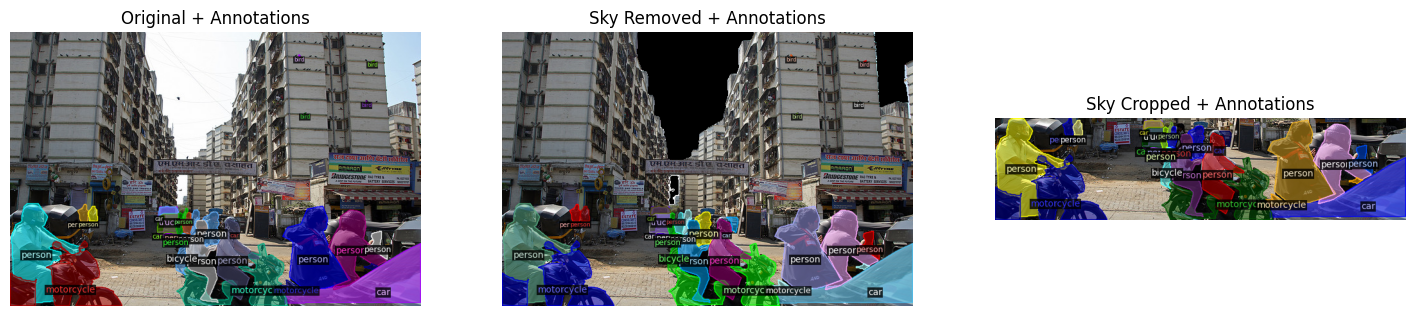

In [48]:
# Visualize one processed image
processor.visualize_processed_image_with_annotations(sample_ids[10])

 10%|█         | 501/5000 [01:17<12:45,  5.88it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_500.json


 20%|██        | 1001/5000 [02:36<11:59,  5.56it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_1000.json


 30%|███       | 1501/5000 [03:54<10:54,  5.34it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_1500.json


 40%|████      | 2001/5000 [05:12<12:21,  4.05it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_2000.json


 50%|█████     | 2501/5000 [06:30<09:01,  4.62it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_2500.json


 60%|██████    | 3001/5000 [07:48<07:35,  4.39it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_3000.json


 70%|███████   | 3501/5000 [09:08<05:59,  4.17it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_3500.json


 80%|████████  | 4001/5000 [10:26<04:12,  3.95it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_4000.json


 90%|█████████ | 4501/5000 [11:44<02:18,  3.60it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_4500.json


100%|██████████| 5000/5000 [13:04<00:00,  6.38it/s]

Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_partial_5000.json


Saved new COCO annotations to coco_sky_removed/annotations/instances_cropped_full.json


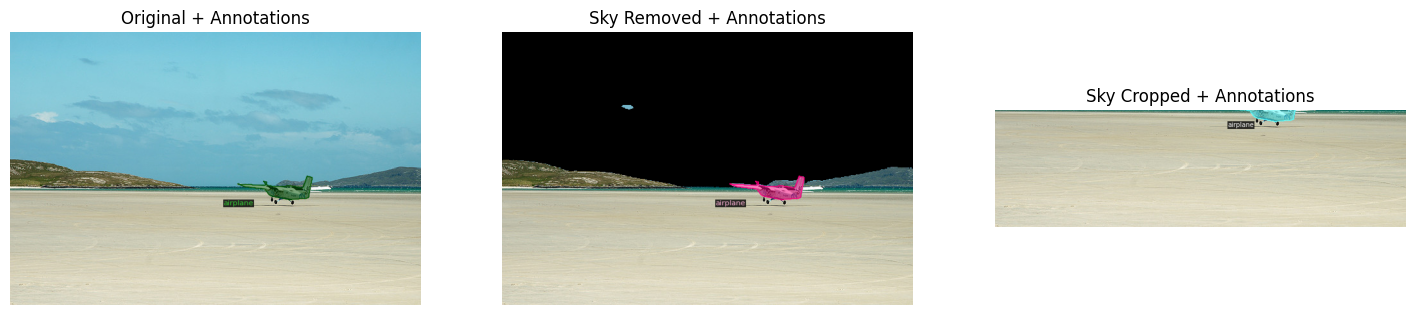

In [50]:
processor = CocoSkyProcessor(coco, predictor, metadata)

# Process all 5000 images safely
all_ids = coco.getImgIds()
processor.process_dataset_sequential(all_ids, save_every=500)

# Save final COCO JSON
processor.save_new_coco_json("instances_cropped_full.json")

# Visualize any processed image
processor.visualize_processed_image_with_annotations(all_ids[500])

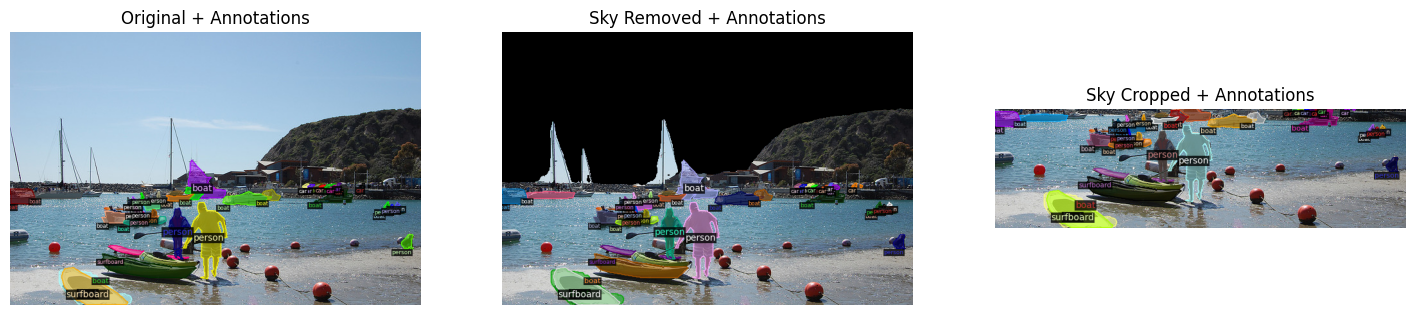

In [51]:
processor.visualize_processed_image_with_annotations(all_ids[1234])